# Expressibility, engtangling capability and Fourier series representation

In [1]:
import warnings
import json
import os
import sys
import glob
import numpy
import pickle
import pennylane as qml

from math import ceil
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
from utils import transform_into_pennylane_circuits, read_diagrams, get_symbols

this_folder = os.path.abspath(os.getcwd())
nshot = 1000

In [2]:
num_of_bins = 75
bins_list = [i/(num_of_bins) for i in range(num_of_bins + 1)]
bins_x = [bins_list[1]+bins_list[i] for i in range(num_of_bins - 1)]


def P_harr(l, u, N):
    return (1-l)**(N-1)-(1-u)**(N-1)


#Harr histogram
P_harr_hist = [P_harr(bins_list[i], bins_list[i+1], 2) for i in range(num_of_bins)]

In [3]:
# Select workload
workload = "execution_time"
#workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 1
layers = 1
single_qubit_params = 3
n_wire_count = 1

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//"\
            + workload + "//" + workload_size + "//circuits//"\
            + str(classification) + "//" + str(layers) + "_layer//"\
           + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count)\
            + "_n_wire_count//"

In [4]:
training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [5]:
training_circuits = read_diagrams(training_circuits_paths)
#validation_circuits = read_diagrams(validation_circuits_paths)
#test_circuits = read_diagrams(test_circuits_paths)

In [6]:
n_qubits = 20
dev = qml.device("default.qubit", wires=n_qubits, shots=nshot)

qml_training_circuits, train_symbols = transform_into_pennylane_circuits(training_circuits, n_qubits, dev)
#qml_test_circuits, test_symbols = transform_into_pennylane_circuits(test_circuits.values(), n_qubits, dev)
#qml_validation_circuits, val_symbols = transform_into_pennylane_circuits(validation_circuits.values(), n_qubits, dev)
qml_circuits = qml_training_circuits #+ qml_test_circuits + qml_validation_circuits

## Studies on circuits as Fourier series

This requires modifications to circuits.

In [7]:
#from pennylane.fourier.visualize import *
#from pennylane.fourier import coefficients
#import matplotlib.pyplot as plt
#circuit = all_circuits[0]
#coeffs = coefficients(circuit, 1, 2)
#print(np.round(coeffs, decimals=4))

## Expressibility

In [8]:
def post_select_circuit_samples(circuit_samples):
    selected_samples = []
    post_select_array = np.array([0]*(circuit_samples[0].size - 1))
    for circuit_sample in circuit_samples:
        if np.array_equal(circuit_sample[1:], post_select_array):
            if circuit_sample[0] == 1:
                selected_samples.append(1)
            else:
                selected_samples.append(0)
    return selected_samples

In [9]:
import random
import collections
fidelity=[]
circuit = qml_circuits["328"]
symbols = train_symbols
for x in range(100):
    params = [2*np.pi*random.uniform(0, 1) for i in range(len(symbols))]
    result = circuit(params)
    post_selected_result = post_select_circuit_samples(result)
    res = collections.Counter(post_selected_result)

    if 0 in res:
        ratio = res[0]/nshot
    else:
        ratio = 0
        
    fidelity.append(ratio)

In [10]:
print(fidelity)

[0.002, 0.004, 0, 0.006, 0, 0, 0.001, 0.003, 0, 0.002, 0.002, 0.001, 0.002, 0.001, 0, 0, 0.009, 0.001, 0, 0.001, 0.001, 0.001, 0.003, 0, 0.001, 0, 0, 0.001, 0.003, 0.001, 0.001, 0.002, 0.012, 0.001, 0.001, 0.01, 0.002, 0.002, 0, 0.003, 0.006, 0.001, 0.006, 0.006, 0, 0, 0.022, 0.003, 0.031, 0.028, 0.002, 0.002, 0.001, 0, 0, 0.001, 0, 0, 0.01, 0, 0, 0.007, 0, 0.02, 0.01, 0.002, 0, 0.002, 0.019, 0, 0, 0.002, 0.003, 0, 0, 0.016, 0, 0.001, 0.007, 0, 0.001, 0.016, 0.001, 0.002, 0.004, 0, 0, 0, 0.007, 0.006, 0, 0, 0, 0.011, 0, 0.006, 0, 0.007, 0, 0]


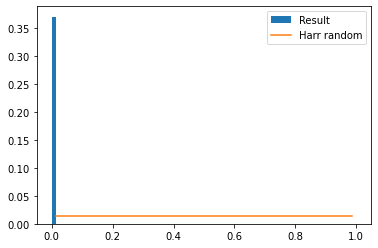

In [13]:
import matplotlib.pyplot as plt
weights = numpy.ones_like(fidelity)/float(len(fidelity))
fidelity = numpy.array([(2**9)*x for x in fidelity])
plt.hist(fidelity, bins=bins_list, weights=weights, label='Result', range=[0, 1])
plt.plot(bins_x, P_harr_hist[:-1], label='Harr random')
plt.legend(loc='upper right')
plt.show()

In [ ]:
P_I_hist = numpy.histogram(fidelity, bins = bins_list, weights = weights, range=[0, 1])[0]
kl_pq = kl_div(P_I_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))